# Part II - Customer Bike Usage Patterns and Trends
## by James Hansen

## Investigation Overview

In this investigation, I wanted to focus on the bike usage pattern over the course of a day, week and month. 

I also included some interesting details uncovered during exploration on customer age and gender.

### Summary of Key Findings
- Most bike trips are about 6-8 minutes in duration.
- Male customers make up 3 times as many customers than females.
- 50% of the bike trip users are under the age of 32.
- Bike usage during the week is higher than the weekends
- Bike usage patterns are cyclical: 
    - Bike usages increasing throughout the week and drops off towards the weekend
    - During the work week, a bimodal cycle appear with peaks around the morning at 8am and afternoon at 6pm
    - During the weekend, bike usage patterns are unimodal with a peak around 1pm

## Dataset Overview

This data set includes information about individual bike rides made in a bike-sharing system covering the greater San Francisco Bay area. There are 183,412 bike trips, including information on trip duration, start/end times and locations, as well as member gender, birth year and customer type.

After preliminary wrangling, the final dataset had 174,952 entries with 19 features.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

# disable warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# Helpful variables
base_color = sb.color_palette()[0]

In [2]:
# load in the dataset into a pandas dataframe
df_clean = pd.read_csv("fordgobike_clean.csv")

In [3]:
# convert nominal features into un-ordered categorical types
nominal_var_dict = {
    "user_type": df_clean.user_type.unique().tolist(),
    "member_gender": df_clean.member_gender.unique().tolist(),
    "bike_share_for_all_trip": df_clean.bike_share_for_all_trip.unique().tolist(),
}

for var in nominal_var_dict:
    unordered_var = pd.api.types.CategoricalDtype(
        ordered=False, categories=nominal_var_dict[var]
    )
    df_clean[var] = df_clean[var].astype(unordered_var)


# Convert start_time and end_timeto dateTime objects
df_clean.start_time = pd.to_datetime(df_clean.start_time)
df_clean.end_time = pd.to_datetime(df_clean.end_time)

In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174952 entries, 0 to 174951
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_time               174952 non-null  datetime64[ns]
 1   end_time                 174952 non-null  datetime64[ns]
 2   start_station_id         174952 non-null  float64       
 3   start_station_name       174952 non-null  object        
 4   start_station_latitude   174952 non-null  float64       
 5   start_station_longitude  174952 non-null  float64       
 6   end_station_id           174952 non-null  float64       
 7   end_station_name         174952 non-null  object        
 8   end_station_latitude     174952 non-null  float64       
 9   end_station_longitude    174952 non-null  float64       
 10  bike_id                  174952 non-null  int64         
 11  user_type                174952 non-null  category      
 12  member_birth_yea

In [5]:
df_clean.head()

,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age,duration_sec,duration_min,duration_hr
0,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984,Male,No,35,52185,869,144
1,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972,Male,No,47,61854,1030,171
2,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989,Other,No,30,36490,608,101
3,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974,Male,Yes,45,1585,26,4
4,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,-122.405950,5200,Subscriber,1959,Male,No,60,1793,29,4


## Distribution of Bike Trip Duration

The bike trip duration takes on a very large range of values from 1 second to 243 hours (or 84848 seconds!). It is also heavily right-skewed. Plotted on a logarithmic scale, the distribution is approximately Gaussian shaped.
This informs us that the average trip duration is between 6 to 8 minutes in length.


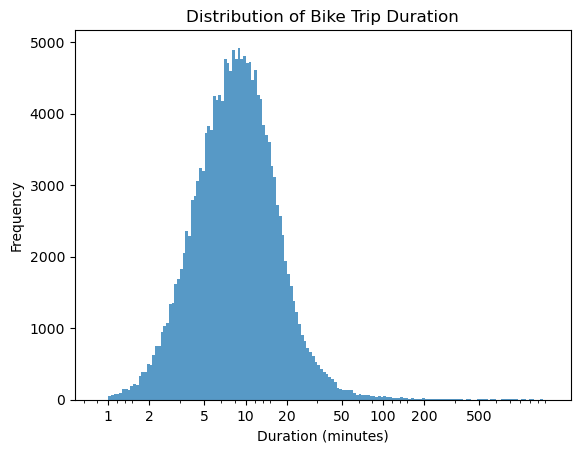

In [6]:
# Axis transformation
# Bin size
bins_log = 10 ** np.arange(1.7, 5, 0.02)

ax = sb.histplot(data=df_clean, x="duration_sec", bins=bins_log)
ax.set_xscale("log")

# Generate the x-ticks
ticks = np.array([60, 120, 300, 600, 1200, 3000, 6000, 12000, 30000])

# Convert ticks into string values, to be displaye along the x-axis
labels = [f"{round(v/60)}" for v in ticks]

plt.xticks(ticks, labels)
plt.title("Distribution of Bike Trip Duration")
plt.xlabel("Duration (minutes)")
ax = plt.ylabel("Frequency")

## Average Bike Usage per Day

Bike usage differs depending on whether the day falls in a work week or a weekend. Bike trips tend to higher from Monday - Friday while Saturday and Sunday bike usage decreases by 42%.

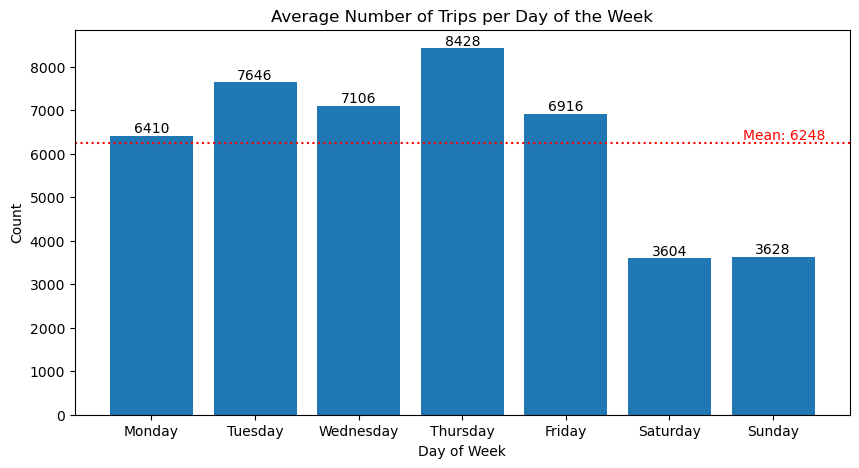

In [7]:
day_name_counts = df_clean.start_time.dt.day_name().value_counts()

# Sort the index by day of the week
day_name_counts = day_name_counts.reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

day_name_average_count = day_name_counts / 4
plt.figure(figsize=(10, 5))
plt.bar(
    x=day_name_average_count.index,
    height=day_name_average_count.values.tolist(),
    color=base_color,
)

plt.axhline(day_name_average_count.mean(), linestyle="dotted", color="red")
plt.text(
    len(day_name_average_count) - 0.5,
    day_name_average_count.mean(),
    f"Mean: {round(day_name_average_count.mean())}",
    ha="right",
    va="bottom",
    color="red",
)
plt.title("Average Number of Trips per Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")

# Add labels for the heights of the bars
for i, count in enumerate(day_name_average_count):
    plt.text(i, count, str(round(count)), ha="center", va="bottom")

plt.show()

## Bike Usage Trends over a month

By observing the total number of bikes trips per day, a clear pattern emerges. A sharp decline over 2-3 days, then a rise and peak over 3-4 days. This follows the Monday - Sunday week,  a typical working cycle.

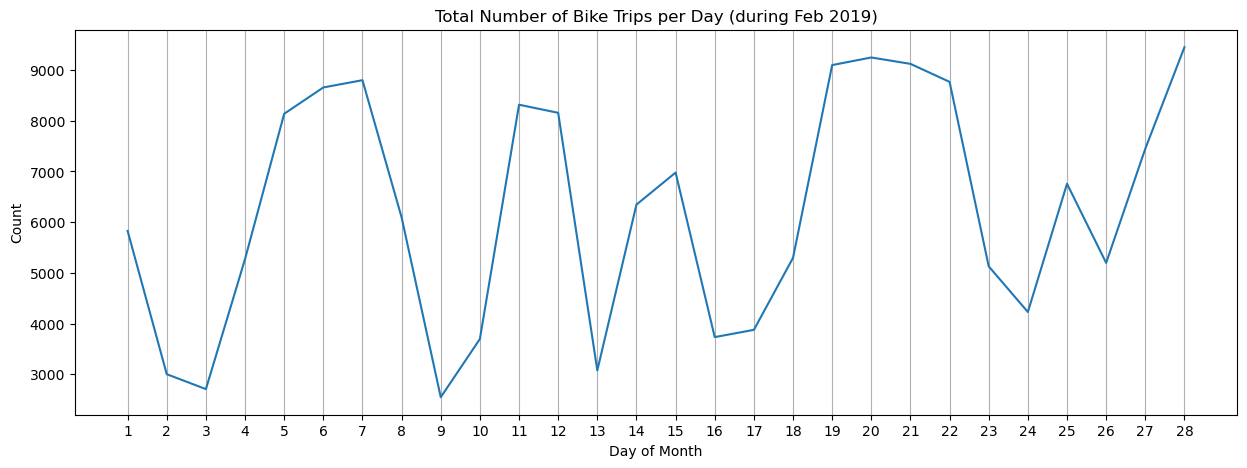

In [8]:
day_counts = df_clean.start_time.dt.day.value_counts().sort_index()
plt.figure(figsize=(15, 5))
plt.plot(day_counts.index, day_counts.values.tolist())

# Generate the x-ticks
ticks = range(1, 29, 1)

# Convert ticks into string values, to be displaye along the x-axis
labels = [f"{v}" for v in ticks]

plt.xticks(ticks, labels)
plt.grid(axis="x")
plt.ylabel("Count")
plt.xlabel("Day of Month")
plt.title("Total Number of Bike Trips per Day (during Feb 2019)")
plt.show()

In [9]:
df_time_series = pd.DataFrame(
    {
        "start_time": df_clean.start_time,
        "day_name": df_clean.start_time.dt.day_name(),
        "weekday": df_clean.start_time.dt.weekday,
        "day": df_clean.start_time.dt.day,
        "hour": df_clean.start_time.dt.hour,
    }
)

grouped_data = (
    df_time_series.groupby(["weekday", "day_name", "hour"])
    .size()  # get number of bikes rented out during hour
    .reset_index(name="total")  # convert to dataframe
    .drop(columns="weekday")  # drop sorting column
)

# COnvert total trips for that hour per week day to average over month (i.e. average number of bikes rented in that hour for that day over the month)
grouped_data["average"] = grouped_data.total / 4

## Bike Usage over a 24 hour cycle

A less granular look at the data unveils a new cyclical pattern. Not only do bike usages vary per day but per hour. During the work week,the usage is bimodal with spikes in the morning and late afternoon; there is also a mini peak around lunch. During the weekend, bike usage is lower indicated by the lower maximal peak but also it is unimodal, peaking around lunch.

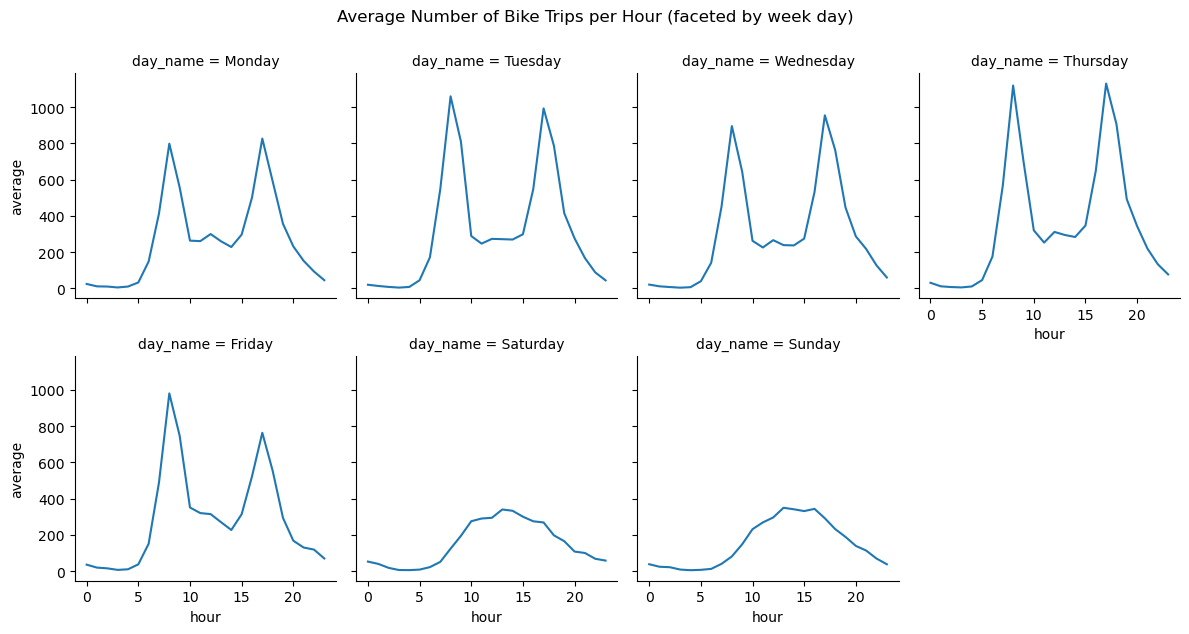

In [10]:
g = sb.FacetGrid(data=grouped_data, col="day_name", col_wrap=4)
g.map(plt.plot, "hour", "average")
g.fig.suptitle("Average Number of Bike Trips per Hour (faceted by week day)", y=1.05)
plt.show()

## Member age by Categorical Features

The box plots indicate a few interesting trends. Firstly, at least 50% of the user are below the ages of 35 years regardless of categorical differences. Secondly, most users are below the age of 60 (near retirement age).


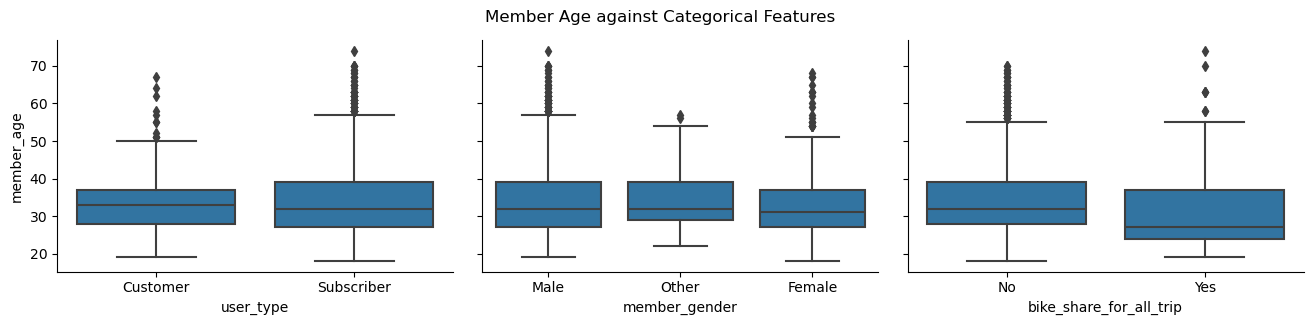

In [11]:
# plot matrix of numeric features against categorical features.

# plot matrix: sample 10K bike trips so that plots render faster
df_clean_samp = df_clean.sample(n=2000, replace=False)


def boxgrid(x, y, **kwargs):
    """Quick hack for creating box plots with seaborn's PairGrid."""
    default_color = sb.color_palette()[0]
    sb.boxplot(x=x, y=y, color=default_color)


g = sb.PairGrid(
    data=df_clean_samp,
    y_vars=["member_age"],
    x_vars=["user_type", "member_gender", "bike_share_for_all_trip"],
    height=3,
    aspect=1.5,
)
g.map(boxgrid)
g.fig.suptitle("Member Age against Categorical Features", y=1.05)
plt.show()

## Distribution of Member Gender

The member gender bar plots have a clear insight: Males make up just over three times the user than females and other combined.


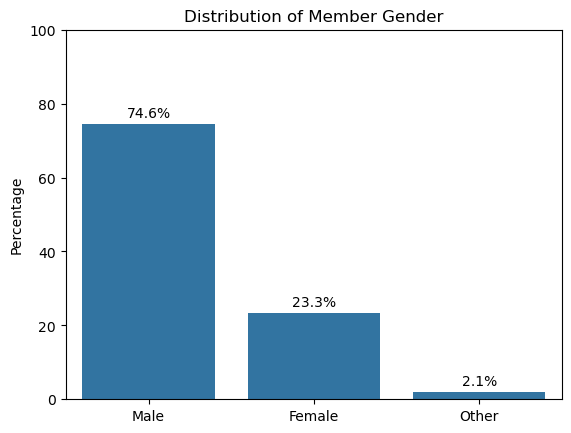

In [12]:
# Calculate the percentage of each gender category
gender_percentage = df_clean["member_gender"].value_counts(normalize=True) * 100

# Plot the percentage distribution with the specified order
ax = sb.barplot(
    x=gender_percentage.index,
    y=gender_percentage.values,
    order=["Male", "Female", "Other"],
    color="tab:blue",
)
plt.title("Distribution of Member Gender")
plt.ylabel("Percentage")
plt.ylim(0, 100)

# Add labels to each bar at the top
for i, v in enumerate(gender_percentage.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom")

plt.show()

## Conclusion

The bike usage cases informs us that the bikes are used probably by working individuals and most of the clientele are young to middle age males. This can help the company in logistics and operations by ensuring there are enough bikes to suit demand and improve profitability as they can target advertisement and sales towards these demographics.

In [13]:
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Part_II_slide_deck.ipynb to slides
[NbConvertApp] Writing 917136 bytes to Part_II_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck.slides.html
Use Control-C to stop this server
^C

Interrupted


In [ ]:
### Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Part_II_exploration.ipynb